In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import gc

In [2]:
# load all the data
df_train = pd.read_csv('../Resources/weather_train.csv')
df_train["timestamp"] = pd.to_datetime(df_train["timestamp"], format='%Y-%m-%d %H:%M:%S')
df_test = pd.read_csv("../Resources/weather_test.csv")
df_test["timestamp"] = pd.to_datetime(df_test["timestamp"], format='%Y-%m-%d %H:%M:%S')
df_filled = pd.read_csv('../Large_output/csv/filled_initial.csv')
df_filled["time"] = pd.to_datetime(df_filled["time"], format='%Y-%m-%d %H:%M:%S')

In [3]:
# load the data from outside we can get
fill_weather = pd.read_csv('../Resources/extra_weather_data/more_weather_locations.csv', index_col=0, 
                           parse_dates=True, infer_datetime_format=True)\
                .join(pd.read_csv('../Resources/extra_weather_data/temperature.csv', index_col=0, parse_dates=True,
                                  infer_datetime_format=True,).sub(273),how='left')

In [4]:
# merge and get the pivot data
weath = pd.concat([df_train, df_test]).set_index(['site_id', 'timestamp'])
weath = weath.reindex(pd.MultiIndex.from_product(
    [range(16), pd.date_range('2016-01-01', '2018-12-31 23:00', freq='H')]))
weath = weath.unstack(level=0).interpolate(limit=2).ffill(limit=1).bfill(limit=1)

In [5]:
# find the corrolation by air_temperature
# reason of not 100% fitting is that they are just super nearby 
# instead of same position or have the missing filling
weath_corr = fill_weather.join(weath['air_temperature']).corr().drop(range(16)).loc[:, range(16)]

site_id_loc_corr = pd.concat([weath_corr.idxmax(), weath_corr.max()], 
                             keys=['location', 'corr'], axis=1).rename_axis('site_id')
site_id_loc_corr

,location,corr
site_id,,
0,orlando,0.971346
1,heathrow,0.985568
2,Phoenix,0.978950
3,washington,0.990834
4,San Francisco,0.927506
5,birmingham,0.944360
6,washington,0.976488
7,ottowa,0.990955
8,orlando,0.971346


/local/home/ningzesun/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


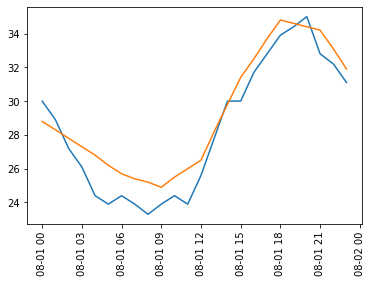

In [6]:
# showing orlando where is EST temperature peak is 19 around suggesting it is UTC time
df_orlando = df_train.loc[df_train['site_id'] == 0,:]
df_orlando = df_orlando[['timestamp', 'air_temperature']]
df_orlando_merge = df_orlando.merge(fill_weather['orlando'], on = 'timestamp', how = 'left')
df_orlando_merge = df_orlando_merge.set_index('timestamp')
data = df_orlando_merge.loc['2016-08-01': '2016-08-01']
plt.plot(data['air_temperature'])
plt.plot(data['orlando'])
plt.xticks(rotation=90)
plt.show()

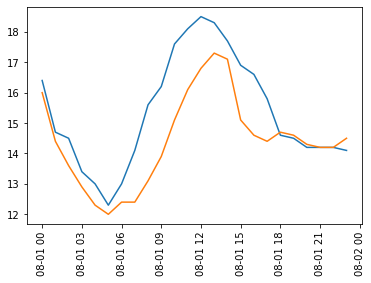

In [7]:
# heathrow is UTC time showing temperature peak is arount 2
df_heathrow = df_train.loc[df_train['site_id'] == 1,:]
df_heathrow = df_heathrow[['timestamp', 'air_temperature']]
df_heathrow_merge = df_heathrow.merge(fill_weather['heathrow'], on = 'timestamp', how = 'left')
df_heathrow_merge = df_heathrow_merge.set_index('timestamp')
data = df_heathrow_merge.loc['2016-08-01': '2016-08-01']
plt.plot(data['air_temperature'])
plt.plot(data['heathrow'])
plt.xticks(rotation=90)
plt.show()

In [8]:
# get the dictionary for the site_id to city name
site_dict  = {}
for loc_name, loc_S in fill_weather.iteritems():
    site_scores = []
    for site_id, site_S in weath.air_temperature.iteritems():
        df = loc_S.to_frame(loc_name).join(site_S)
        site_scores.append(df.diff(axis=1).pow(2).mean().pow(0.5).iat[1])
    site_dict[loc_name] = site_scores
temp_rmse = pd.DataFrame(site_dict, index=range(16))
temp_rmse = temp_rmse.drop('San Antonio', axis=1)
site_loc_rmse = pd.concat([temp_rmse.idxmin(axis=1), temp_rmse.min(axis=1)], keys=['location', 'RMSE'], axis=1).rename_axis('site_id')
site_name = site_loc_rmse.location.to_dict()

In [9]:
# resite the location based on correction
site_temp = {'orlando': 0, 'heathrow': 1, 'Phoenix': 2, 'washington': 3, 'sanfranitl': 4,
             'birmingham': 5, 'ottowa': 6, 'sanantonio': 7, 'saltlake': 8, 'dublin': 9,
             'Minneapolis': 10, 'Philadelphia': 11, 'rochester': 12,}
site_cor = {}
for i in site_name.keys():
    site_cor[i] = site_temp[site_name[i]]

In [11]:
# check the correlation of weather csv and collected data from darkweather api
site_real_cor = {}
weather_list = {'air_temperature': 'apparentTemperature', 'cloud_coverage': 'cloudCover', 
                'dew_temperature': 'dewPoint', 'precip_depth_1_hr': 'precipIntensity'}

for j in weather_list.keys():
    temp_cor = {}
    pivot_weather = df_correct.pivot(index = 'time', columns = 'site_id', values = weather_list[j])
    pivot_real = pd.concat([df_train, df_test]).pivot(index = 'timestamp', columns = 'site_id', 
                                                      values = j)
    for i in site_cor.keys():
        weather_corr = pd.concat([pivot_weather[site_cor[i]], pivot_real[i]], axis = 1).corr().reset_index()
        weather_corr.columns = [0,1,2]
        temp_cor[i] = weather_corr[2][0]
    site_real_cor[j] = temp_cor

In [12]:
pd.DataFrame.from_dict(site_real_cor)

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
0,0.975828,0.648649,0.988543,0.478750
1,0.991228,0.294096,0.986224,NaN
2,0.990138,0.689029,0.983118,0.300045
3,0.990203,0.782995,0.994323,0.580863
4,0.938549,0.541697,0.914351,0.746662
5,0.939236,0.228580,0.942338,NaN
6,0.977308,0.405792,0.981641,0.190722
7,0.992480,NaN,0.997667,0.536967
8,0.975828,0.648649,0.988543,0.478750
9,0.979778,0.447240,0.981883,0.299041


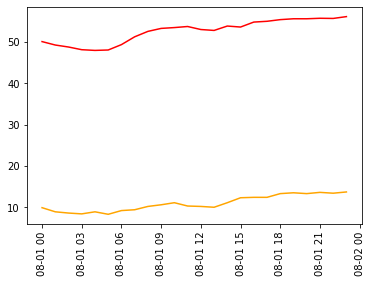

In [13]:
# heathrow is UTC time showing temperature peak is arount 2
df_heathrow = df_train.loc[df_train['site_id'] == 1,:]
df_heathrow = df_heathrow[['timestamp', 'dew_temperature']]
df_heathrow_merge = pd.merge(df_heathrow, df_filled.loc[df_filled['site_id'] == 1,['dewPoint', 'time']],
                              right_on = 'time', left_on = 'timestamp', how = 'left')
df_heathrow_merge = df_heathrow_merge.set_index('timestamp')
data = df_heathrow_merge.loc['2016-08-01': '2016-08-01']
plt.plot(data['dew_temperature'], color = 'orange')
plt.plot(data['dewPoint'], color = 'red')
plt.xticks(rotation=90)
plt.show()

In [14]:
# find the regression of dew_temperature and the filled
j = 'dew_temperature'
slope = []
intercept = []
pivot_weather = df_correct.pivot(index = 'time', columns = 'site_id', values = weather_list[j])
pivot_real = pd.concat([df_train, df_test]).pivot(index = 'timestamp', columns = 'site_id', values = j)
for i in site_cor.keys():
    dew_model = LinearRegression()
    weather_corr = pd.concat([pivot_weather[site_cor[i]], pivot_real[i]], axis = 1).dropna()
    weather_corr.columns = ['x', 'y']
    x = np.array(weather_corr['x']).reshape(-1, 1)
    y = np.array(weather_corr['y']).reshape(-1, 1)
    dew_model.fit(x, y)
    temp = dew_model.coef_
    slope.append(list(dew_model.coef_[0])[0])
    temp = dew_model.intercept_
    intercept.append(list(temp)[0])

In [15]:
# fill in the air temperature, cloud coverage and description in test weather csv
df_test['description'] = ''
for i in df_test.index:
    site_id = df_test['site_id'][i]
    time_stamp = df_test['timestamp'][i]
    if pd.isnull(df_test['air_temperature'][i]):
        site_id = df_test['site_id'][i]
        time_stamp = df_test['timestamp'][i]
        df_test['air_temperature'][i] = fill_weather[site_name[site_id]][time_stamp]
    if pd.isnull(df_test['cloud_coverage'][i]):
        try:
            df_test['cloud_coverage'][i] = df_filled.loc[df_filled['site_id'] == site_cor[df_test['site_id'][i]], 'cloudCover']\
            .loc[df_filled['time'] == df_test['timestamp'][i]].values[0] * 10
        except:
            df_test['cloud_coverage'][i] = np.nan
    try:
        df_test['description'][i] = df_filled.loc[df_filled['site_id'] == site_cor[df_test['site_id'][i]], 'icon']\
        .loc[df_filled['time'] == df_test['timestamp'][i]].values[0]
    except:
        df_test['description'][i] = np.nan

In [16]:
# fill in the air temperature, cloud coverage and description in train weather csv
df_train['description'] = ''
for i in df_train.index:
    site_id = df_train['site_id'][i]
    time_stamp = df_train['timestamp'][i]
    if pd.isnull(df_train['air_temperature'][i]):
        site_id = df_train['site_id'][i]
        time_stamp = df_train['timestamp'][i]
        df_train['air_temperature'][i] = fill_weather[site_name[site_id]][time_stamp]
    if pd.isnull(df_train['cloud_coverage'][i]):
        try:
            df_train['cloud_coverage'][i] = df_filled.loc[df_filled['site_id'] == site_cor[df_train['site_id'][i]], 'cloudCover']\
            .loc[df_filled['time'] == df_train['timestamp'][i]].values[0] * 10
        except:
            df_train['cloud_coverage'][i] = np.nan
    try:
        df_train['description'][i] = df_filled.loc[df_filled['site_id'] == site_cor[df_train['site_id'][i]], 'icon']\
        .loc[df_filled['time'] == df_train['timestamp'][i]].values[0]
    except:
        df_train['description'][i] = np.nan

In [17]:
# fill the dew_temperature
df_list = [df_train_filled, df_test_filled]
for j in df_list:
    for i in j.index:
        site_id = j['site_id'][i]
        time_stamp = j['timestamp'][i]
        if pd.isnull(j['dew_temperature'][i]):
            try:
                j['dew_temperature'][i] = df_filled.loc[df_filled['site_id'] == site_cor[j['site_id'][i]], 'dewPoint']\
                .loc[df_filled['time'] == j['timestamp'][i]].values[0] * slope[site_id] + intercept[site_id]
            except:
                j['dew_temperature'][i] = np.nan

In [18]:
df_test_filled.to_csv('../../../Large_output/csv/fill_test_weather.csv')
df_train_filled.to_csv('../../../Large_output/csv/fill_train_weather.csv')

In [19]:
del df_heathrow, df_heathrow_merge, site_loc_rmse, df_orlando_merge, df_orlando, df_filled, df_test
gc.collect()

7603